In [174]:
#!pip install -U kaleido
from __future__ import print_function
import math
from sklearn import linear_model
from sklearn.model_selection import (cross_val_predict, cross_val_score, train_test_split, 
                                     LeaveOneGroupOut, GridSearchCV, cross_validate,
                                     StratifiedKFold, GroupKFold, KFold
                                    )
from sklearn.linear_model import (SGDClassifier,SGDRegressor,LogisticRegression)
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_array, column_or_1d
from sklearn.utils.multiclass import type_of_target
from sklearn.decomposition import PCA
from sklearn.externals.joblib import parallel_backend
from sklearn.metrics.pairwise import paired_distances
from sklearn.metrics.pairwise import manhattan_distances

import sklearn
import numpy as np
import pandas as pd
import time
import os 
import sys
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from functools import wraps
import pickle

print('python', sys.version_info)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('sklearn', sklearn.__version__)

t1 = time.time()

local_desktop_run=0 
total_algo_list=["lin_reg","log_clfn","keras_reg","keras_clfn","pca"]
algo_active_list=total_algo_list[:]
print("")
print(algo_active_list," = active algos")

python sys.version_info(major=2, minor=7, micro=16, releaselevel='final', serial=0)
pandas 0.24.2
numpy 1.16.5
sklearn 0.20.3

['lin_reg', 'log_clfn', 'keras_reg', 'keras_clfn', 'pca']  = active algos


In [175]:
source_selection=0
sourcelist=["fp","vivax"]
source=sourcelist[source_selection]
print(source," = active source data")

fp  = active source data


In [176]:
###key settings
use_simulated_data=1
use_real_data=0
calculate_out_of_folds=1
plotting_enabled=0

cross_validate_new=0
CV_FOLDS = 4

select_subset_columns=0
subset_columns=1000
sub_sample_samples=1
number_sub_samples=10000
remove_small_values=1
n_jobs_log_clfn=-1
n_jobs_2reg=-1

patience_setting=1000 
optimizer_selected="SGD"

In [177]:
###imputation
replaceN=1
replace_05=1
recode_float=1
verbose=0

###CNN
cnn_nlayers=8 
cnn_width=64 
cnn_dropout_prop=0.25
cnn_max_epochs=1200 
cnn_batch_size=64
keras_verbose = 0

###test_training_set
holdout_size_perc = 0.2  
test_perc=0.5 ###percentage to split holidout in test and validation 

### seed
seed_value=1

rudimentary_calculation = 0
import geopy.distance as geo_distance
import geopy
import tensorflow as tf
from tensorflow.keras import backend as K
print('geopy', geopy.__version__)
print('tensorflow', tf.__version__)

###cross_validation_range and files
cv_params_regression=np.logspace(-3, 0, 7); print(cv_params_regression)
cv_params_classifier=np.logspace(-3, 0, 7); print(cv_params_classifier)

if source=="fp":
    if use_simulated_data==1:
        logistic_classifier_input_file='clf_sim.dat'
        linear_regression_input_file='2reg_sim.dat'
    else:
        pass
elif source=="vivax":
    if use_simulated_data==1:
        logistic_classifier_input_file='clf_vivax_sim.dat'
        linear_regression_input_file='2reg_vivax_sim.dat'
    else:
        pass
    
#######################################################################
##### logistic classification wrapper
if "log_clfn" in algo_active_list:
    try:
        print(sklearn.externals.joblib.load(logistic_classifier_input_file))
    except:
        pass
        
    if cross_validate_new==1:
        try:
            os.remove(logistic_classifier_input_file)
            grid_search_title=logistic_classifier_input_file+".grid_search"
            os.remove(grid_search_title)
        except:
            pass
    else: 
        pass

#######################################################################
##### Linear Regressor wrapper
if "lin_reg" in algo_active_list:
    try:
        sklearn.externals.joblib.load(linear_regression_input_file)
    except:
        pass

    if cross_validate_new==1:
        try:
            os.remove(linear_regression_input_file)
            grid_search_title=linear_regression_input_file+".grid_search_vivax"
            os.remove(grid_search_title)
        except:
            pass
    else: 
        pass

# Set a seed value
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
#from https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752

####filenaming
def relabel_title_to_simdata(title):
    return(title.rsplit('.', 1)[0]+"_simdata."+title.rsplit('.', 1)[1])

def relabel_title_to_vivax(title):
    return(title.rsplit('.', 1)[0]+"_vivax."+title.rsplit('.', 1)[1])

file_out_dict={"file_out_lin_regr_plot": "linear_regr_eval_map_plot.png",
"file_out_log_clfn_plot": "log_clfn_eval_map_plot.png",
"file_out_keras_regr_plot": "keras_regr_eval_map_plot.png",
"file_out_keras_clfn_plot":"keras_clfn_eval_map_plot.png",  

"file_out_lin_regr_holdout": "linear_regr_eval_on_holdout.csv",
"file_out_log_clfn_holdout": "log_classification_eval_on_holdout.csv",
"file_out_keras_regr_holdout": "keras_regr_eval_on_holdout.csv",
"file_out_keras_clfn_holdout": "keras_clfn_eval_on_holdout.csv",

"file_out_lin_regr_holdout_grouped": "linear_regr_eval_on_holdout_grouped.csv",
"file_out_log_clfn_holdout_grouped": "log_classification_eval_on_holdout_grouped.csv",
"file_out_keras_regr_holdout_grouped": "keras_regr_eval_on_holdout_grouped.csv",
"file_out_keras_clfn_holdout_grouped": "keras_clfn_eval_on_holdout_grouped.csv",

"file_out_lin_regr_oof_preds":"linear_regr_oof_predictions.csv",
"file_out_log_clfn_oof_preds":"log_classification_oof_predictions.csv",
"file_out_keras_regr_oof_preds":"keras_regr_oof_predictions.csv",
"file_out_keras_clfn_oof_preds":"keras_clfn_oof_predictions.csv",

"file_out_lin_regr_coef":"linear_regr_coef.csv",
"file_out_log_clfn_coef":"log_classification_coef.csv",
"file_out_keras_regr_coef":"keras_regr_coef.csv",
"file_out_keras_clfn_coef":"keras_clfn_coef.csv",
               
"file_out_snp_diversity":"snp_diversity.csv",

"file_out_model_by_geography": "model_comparison_by_geography.csv"}

if use_simulated_data==1:
    file_out_dict={key:relabel_title_to_simdata(values) for key,values in file_out_dict.items()} 
else:
    print("error")

if source=="vivax":
    file_out_dict={key:relabel_title_to_vivax(values) for key,values in file_out_dict.items()} 
else:
    pass

geopy 1.23.0
tensorflow 2.1.0
[0.001      0.00316228 0.01       0.03162278 0.1        0.31622777
 1.        ]
[0.001      0.00316228 0.01       0.03162278 0.1        0.31622777
 1.        ]
{'clf__alpha': 0.1}


In [178]:
if source=="fp":
    code_running_success="code_running_success_fp.txt"
    read_in_success="read_in_success_fp.txt"
    lin_regr_success="lin_regr_success_fp.txt"
    log_class_success="log_class_success_fp.txt"
    keras_regr_success="keras_regr_success_fp.txt"
    keras_classifier_success="keras_classifier_success_fp.txt"
elif source=="vivax":
    code_running_success="code_running_success_vivax.txt"
    read_in_success="read_in_success_vivax.txt"
    lin_regr_success="lin_regr_success_vivax.txt"
    log_class_success="log_class_success_vivax.txt"
    keras_regr_success="keras_regr_success_vivax.txt"
    keras_classifier_success="keras_classifier_success_vivax.txt"
else:
    pass

In [179]:
###input files
simulated_inputfile_genome = simulated_inputfile_geo = inputfile = "Dummy_Dataset_2A.xlsx"
holdout_locs = ["Bahamas"]  ###this is for the simulated data
OOF_SELECTED_LOCATIONS = [u'Tanzania', u'Peru']

In [180]:
file_out_dict

{'file_out_keras_clfn_coef': 'keras_clfn_coef_simdata.csv',
 'file_out_keras_clfn_holdout': 'keras_clfn_eval_on_holdout_simdata.csv',
 'file_out_keras_clfn_holdout_grouped': 'keras_clfn_eval_on_holdout_grouped_simdata.csv',
 'file_out_keras_clfn_oof_preds': 'keras_clfn_oof_predictions_simdata.csv',
 'file_out_keras_clfn_plot': 'keras_clfn_eval_map_plot_simdata.png',
 'file_out_keras_regr_coef': 'keras_regr_coef_simdata.csv',
 'file_out_keras_regr_holdout': 'keras_regr_eval_on_holdout_simdata.csv',
 'file_out_keras_regr_holdout_grouped': 'keras_regr_eval_on_holdout_grouped_simdata.csv',
 'file_out_keras_regr_oof_preds': 'keras_regr_oof_predictions_simdata.csv',
 'file_out_keras_regr_plot': 'keras_regr_eval_map_plot_simdata.png',
 'file_out_lin_regr_coef': 'linear_regr_coef_simdata.csv',
 'file_out_lin_regr_holdout': 'linear_regr_eval_on_holdout_simdata.csv',
 'file_out_lin_regr_holdout_grouped': 'linear_regr_eval_on_holdout_grouped_simdata.csv',
 'file_out_lin_regr_oof_preds': 'linear_r

In [181]:
def open_excel(filename,sheet):
    xl = pd.ExcelFile(filename)
    print(xl.sheet_names)
    df = xl.parse(sheet)
    return df

def read_data(inputfile, holdout_locs): ###original function from AP
    ###read in the dataset
    df = pd.read_excel(inputfile, sheet_name="Matrix", index=True)
    drop_column = 'Second_ID' if 'Second_ID' in df.columns else "Position"
    if df.columns[0] == 'Sample':
        df.rename(columns={'Sample': 'Geography'}, inplace=True)
        
    df.drop(columns=[drop_column], inplace=True) #drop the position column, the sample identifier should be the index 
    print('data shape: ', df.shape)
    df_geo = pd.read_excel(inputfile, sheet_name="Geo_data")[['Sample', 'Location', 'Lat', 'Long']]
    print('geo shape: ', df_geo.shape)
    df_merged = pd.merge(df, df_geo, how='left', left_on='Geography', right_on='Sample')
    print('merged shape: ', df_merged.shape)
    
    # drop unmatched rows
    location_cols = ['Location', 'Lat', 'Long']
    empty_vals = df_merged[location_cols].isna().sum(axis=0)
    print('number of columns with missing values:', (empty_vals > 0).sum())
    print(empty_vals[empty_vals > 0].to_frame().T)
    df_merged.dropna(subset=location_cols, axis=0, how='any', inplace=True)
    print('after dropping columns with missing values merged shape = ', df_merged.shape)
    
    # split merged data into parts
    geography = df_merged.Geography.to_frame()
    df_geo = df_merged[df_geo.columns].copy()
    df = df_merged[df.columns].drop(columns='Geography').copy()
    
    # get X and y for training
    y_label = df_geo["Location"] 
    label_enc = sklearn.preprocessing.LabelEncoder()
    y = pd.Series(label_enc.fit_transform(y_label))
    y_lat = df_geo["Lat"] 
    y_lon = df_geo["Long"]         
    hold_out_indicator = y_label.isin(holdout_locs)
    
    location_dict = df_geo.drop(columns='Sample').groupby('Location').first().to_dict(orient='index')
    
    return df, y, y_label, y_lat, y_lon, df_geo, hold_out_indicator, label_enc, location_dict

def load_dataset_simulated_genomic_data(inputfile_genome, holdout_locs):
    df = pd.read_excel(inputfile_genome, sheet_name="Matrix", index=True)
    drop_column = 'Second_ID' if 'Second_ID' in df.columns else "Position"
    df.drop(columns=[drop_column], inplace=True) #drop the position column, the sample identifier should be the index 
    print('data shape: ', df.shape)
    return df 

def load_dataset_simulated_geo_data(inputfile_geo,holdout_locs):
    df_geo = pd.read_excel(inputfile_geo, sheet_name="Geo_data")[['Sample', 'Location', 'Lat', 'Long']]
    print('geo shape: ', df_geo.shape)
    return df_geo
    
def combine_and_clean_data(df, df_geo,holdout_locs):
    # in the dummy dataset - the samples in df and df_geo are in the same order, 
    # but that might not be the case in all datasets, 
    # so we might want to merge and subsequently split to esnsure no issues here
    df_merged = pd.merge(df, df_geo, how='left', left_on='Sample', right_on='Sample')
    print('merged shape: ', df_merged.shape)
    
    # drop unmatched rows
    location_cols = ['Location', 'Lat', 'Long']
    empty_vals = df_merged[location_cols].isna().sum(axis=0)
    print('number of columns with missing values:', (empty_vals > 0).sum())
    print(empty_vals[empty_vals > 0].to_frame().T)
    df_merged.dropna(subset=location_cols, axis=0, how='any', inplace=True)
    print('after dropping columns with missing values merged shape = ', df_merged.shape)
    
    # split merged data into parts
    #geography = df_merged.Geography.to_frame()
    df_geo = df_merged[df_geo.columns].copy()
    df = df_merged[df.columns].drop(columns='Sample').copy()
    
    # get X and y for training
    y_label = df_geo["Location"] 
    label_enc = sklearn.preprocessing.LabelEncoder()
    y = pd.Series(label_enc.fit_transform(y_label))
    y_lat = df_geo["Lat"] 
    y_lon = df_geo["Long"]         
    hold_out_indicator = y_label.isin(holdout_locs)
    
    location_dict = df_geo.drop(columns='Sample').groupby('Location').first().to_dict(orient='index')
    
    return df, y, y_label, y_lat, y_lon, df_geo, hold_out_indicator, label_enc, location_dict

def subset_array_based_on_filter_out_list(inputarray,array_with_values_to_keep,extra_values_to_keep):
    extra_values_to_keep=np.array(extra_values_to_keep)
    array_with_values_to_keep=np.concatenate((extra_values_to_keep, array_with_values_to_keep)) 
    boolean_vector=np.in1d(inputarray,array_with_values_to_keep)
    return(boolean_vector)

if verbose==1:
    a=np.array([1,2,3,4,5]);test = np.array([3,4]);extra=[2]
    bool_vector=subset_array_based_on_filter_out_list(a,test,extra); print(bool_vector)

def change_index_to_column(dm,colname): 
    dm[colname] = dm.index
    cols = list(dm)
    cols.insert(0, cols.pop(cols.index(colname))) ###move the prevous index column to the first column
    dm = dm.ix[:, cols]
    dm.reset_index(drop=True, inplace=True) ###remove index column
    dm.columns.name = None ###remove index column name
    return(dm)

def rounding_to_ten(input, round_value=10):
    return(np.round(np.true_divide(input, round_value),0) * round_value)

a=1234.5
print('round(', a, ') = ', rounding_to_ten(a))

def rounded_euclidean_distance_km(point_1, point_2, round_value=10):
    kilometers_in_one_degree = 110.25
    lat1, lat2 = [rounding_to_ten(p[0], round_value=round_value) 
                  for p in [point_1, point_2]] 
    lng1, lng2 = [rounding_to_ten(p[1], round_value=round_value) 
                  for p in [point_1, point_2]] 
    x = lat2 - lat1
    y = (lng2 - lng1) * np.cos(lat1)
    return np.sqrt(x*x + y*y) * kilometers_in_one_degree

test_point_1, test_point_2 = (3.144, 46.471),  (10.885, -1.086)
print('test points', test_point_1, test_point_2)
print('rounded euclidean distance = ', rounded_euclidean_distance_km(test_point_1, test_point_2))

if local_desktop_run==0:
    print('geo_distance = ', geo_distance.distance(test_point_1, test_point_2).km)

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        
def ml_data_holdout_split(hold_out_indicator, *dataframes, **options):
    """
    spcdlits each of dataframes into 2 frames:
        - second contains all from hold_out_indicator and `test_size` rows from other locations
        - first contains all remaining rows
    """
    df_ho_list = [_df[hold_out_indicator].copy() for _df in dataframes]
    df_ml_data_list = [_df[~hold_out_indicator].copy() for _df in dataframes]
    
    splitted = train_test_split(*df_ml_data_list, **options)
    result = []
    for df_ho, (df_ml_data, df_holdout) in zip(df_ho_list, chunks(splitted, 2)):
        df_holdout_full = pd.concat([df_ho, df_holdout], axis=0, ignore_index=True)
        result.extend([df_ml_data.reset_index(drop=True), ### check result
                       df_holdout_full.reset_index(drop=True)]) ### check result
    return result

class BinomialImputer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
        
    def fit(self, X, y, **params):
        self.p_per_column = np.true_divide(np.sum(X==1, axis=0), 
                                           np.sum((X==0) | (X==1), axis=0))
        return self
        
    def transform(self, X):
        result = X.copy()
        for col, p in zip(X.columns, self.p_per_column):
            
            na_idx = result[col].isna()
            na_count = na_idx.sum()
            if na_count > 0:
                #print(p)
                result.loc[na_idx, col] = np.random.binomial(1, p, size=na_count)
        return result
    
class StratifiedKFoldByGroup(StratifiedKFold):

    def _make_test_folds(self, X, yyy=None, groups=None):
        rng = self.random_state
        groups = np.asarray(groups)
        groups = column_or_1d(groups)
        n_samples = groups.shape[0]
        unique_groups, groups_inversed = np.unique(groups, return_inverse=True)
        groups_counts = np.bincount(groups_inversed)
        min_groups = np.min(groups_counts)
        if np.all(self.n_splits > groups_counts):
            raise ValueError("n_splits=%d cannot be greater than the"
                             " number of members in each group."
                             % (self.n_splits))
        if self.n_splits > min_groups:
            warnings.warn(("The least populated class in y has only %d"
                           " members, which is too few. The minimum"
                           " number of members in any class cannot"
                           " be less than n_splits=%d."
                           % (min_groups, self.n_splits)), Warning)

        # pre-assign each sample to a test fold index using individual KFold
        # splitting strategies for each class so as to respect the balance of
        # classes
        # NOTE: Passing the data corresponding to ith class say X[y==class_i]
        # will break when the data is not 100% stratifiable for all classes.
        # So we pass np.zeroes(max(c, n_splits)) as data to the KFold
        per_cls_cvs = [
            KFold(self.n_splits, 
                  shuffle=self.shuffle,
                  random_state=rng).split(np.zeros(max(count, self.n_splits)))
            for count in groups_counts]

        test_folds = np.zeros(n_samples, dtype=np.int)
        for test_fold_indices, per_cls_splits in enumerate(zip(*per_cls_cvs)):
            for cls, (_, test_split) in zip(unique_groups, per_cls_splits):
                cls_test_folds = test_folds[groups == cls]
                #print(test_fold_indices, cls, np.sum(groups == cls), len(cls_test_folds), test_split)
                
                # the test split can be too big because we used
                # KFold(...).split(X[:max(c, n_splits)]) when data is not 100%
                # stratifiable for all the classes
                # (we use a warning instead of raising an exception)
                # If this is the case, let's trim it:
                test_split = test_split[test_split < len(cls_test_folds)]
                cls_test_folds[test_split] = test_fold_indices
                test_folds[groups == cls] = cls_test_folds

        return test_folds

    def _iter_test_masks(self, X, y=None, groups=None):
        test_folds = self._make_test_folds(X, y, groups)
        for i in range(self.n_splits):
            yield test_folds == i

    def split(self, X, y, groups=None):
        y = check_array(y, ensure_2d=False, dtype=None)
        groups = check_array(groups, ensure_2d=False, dtype=None)
        return super(StratifiedKFoldByGroup, self).split(X, y, groups)
    
def calc_mid_point_with_coefs(lat_lon_points_in_degrees, coefs):
    sum_x = 0
    sum_y = 0
    sum_z = 0
    sum_coefs = 0

    for ((lat_degree, lon_degree), coef) in zip(lat_lon_points_in_degrees, coefs):
        lat = math.radians(lat_degree)
        lng = math.radians(lon_degree)
        
        sum_x += coef * math.cos(lat) * math.cos(lng)
        sum_y += coef * math.cos(lat) * math.sin(lng)
        sum_z += coef * math.sin(lat)
        
        sum_coefs += coef

    sum_x = sum_x / sum_coefs
    sum_y = sum_y / sum_coefs
    sum_z = sum_z / sum_coefs
    
    lng = math.atan2(sum_y, sum_x)
    hyp = math.sqrt(sum_x ** 2 + sum_y ** 2)
    lat = math.atan2(sum_z, hyp)

    return {'latitude': math.degrees(lat),
            'longitude': math.degrees(lng)}

def calc_midpoint(preds_proba, loc_dict):
    pairs = [((location['Lat'], location['Long']),
              preds_proba[loc_name]) 
             for loc_name, location in loc_dict.items()
             if loc_name in preds_proba]
    lat_lon_points, coefs = zip(*pairs)
    mid_point = calc_mid_point_with_coefs(lat_lon_points, coefs)
    return pd.Series([mid_point['latitude'], mid_point['longitude']], 
                     index=['mid_lat', 'mid_long'])

def distance_to_midpoint(row_proba):
    mid_lat = row_proba['mid_lat']
    mid_lon = row_proba['mid_long']
    true_lat = row_proba['true_lat']
    true_lon = row_proba['true_long']
    if rudimentary_calculation==1:
        return rounded_euclidean_distance_km((mid_lat, mid_lon), (true_lat, true_lon))
    else:
        return geo_distance.distance((mid_lat, mid_lon), (true_lat, true_lon)).km

def predict_on_holdout(estimator, df_holdout, y_holdout, location_dict, label_encoder):
    holdout_proba = estimator.predict_proba(df_holdout)
    df_holdout_proba = pd.DataFrame(holdout_proba, 
                                 columns=[label_encoder.inverse_transform([cls])[0] 
                                          for cls in estimator.classes_])
    holdout_pred = holdout_proba.argmax(axis=1)
    df_holdout_proba['pred_location_label'] = label_encoder.inverse_transform(estimator.classes_[holdout_pred])
    df_holdout_proba[['mid_lat', 'mid_long']] = df_holdout_proba.apply(calc_midpoint,
                                                                 axis=1, 
                                                                 loc_dict=location_dict)
    
    df_holdout_proba['true_location_label'] = label_enc.inverse_transform(y_holdout)
    df_holdout_proba['true_lat'] = df_holdout_proba['true_location_label'].map(lambda l: location_dict[l]['Lat'])
    df_holdout_proba['true_long'] = df_holdout_proba['true_location_label'].map(lambda l: location_dict[l]['Long'])

    df_holdout_proba['distance_to_midpoint'] = df_holdout_proba.apply(distance_to_midpoint, axis=1)
    return df_holdout_proba

def plot_eval_on_holdout_sample(eval_on_holdout_sample, save=0,save_fpath=None):
    
    fig = go.Figure()

    for i, row in eval_on_holdout_sample.iterrows():
        fig.add_trace(
            go.Scattergeo(
                    lon = [row['true_long'], row['mid_long']],
                    lat = [row['true_lat'], row['mid_lat']],
                    mode = 'lines',
                    line = dict(width = 1,color = 'red'),
                    opacity = .5,
                    showlegend=False,
                    hoverinfo='text',
                    text='distance = %.2f km' % row['distance_to_midpoint']
                )
            )

    text = ('Lat = ' + eval_on_holdout_sample.mid_lat.round(3).astype(str)
            + ' Lon = ' + eval_on_holdout_sample.mid_long.round(3).astype(str)
            + '<br>distance = ' + eval_on_holdout_sample['distance_to_midpoint'].round().astype(str) 
            + ' km')
    fig.add_trace(go.Scattergeo(name='Predicted MidPoint',
                                hoverinfo='text',
                                lat=eval_on_holdout_sample['mid_lat'],
                                lon=eval_on_holdout_sample['mid_long'],
                                text=text, #eval_on_holdout_sample['distance_to_midpoint'],
                                marker = dict(
                                    color = 'rgb(255, 0, 0)',
                                )
                               )
                 )
    true_loc = eval_on_holdout_sample.drop_duplicates(subset=['true_location_label', 'true_lat', 'true_long'])
    text = (true_loc['true_location_label'] 
            + '<br>Lat = ' + true_loc.mid_lat.round(3).astype(str)
            + ' Lon = ' + true_loc.mid_long.round(3).astype(str))
    fig.add_trace(go.Scattergeo(name='True Location',
                                hoverinfo='text',
                                lat=true_loc['true_lat'],
                                lon=true_loc['true_long'],
                                text=text,
                                marker = dict(
                                    color = 'rgb(0, 0, 255)',
                                )
                               )
                 )


    fig.update_layout(
        geo = dict(
            projection_type = 'natural earth',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    config = {'displaylogo': False}
    fig.show(config=config)
    if save==1:
        if save_fpath is not None:
            fig.write_image(save_fpath, engine="orca")
    return fig

def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
def save_to_csv(func):
    @wraps(func)
    def decorator(*args, **kwargs):
        data = func(*args, **kwargs)
        if 'filename' in kwargs:
            filename = kwargs['filename']
            if filename is not None:
                pd.DataFrame(data).to_csv(filename)
        return data
    return decorator

def get_holdout_mean_distance_error(df):
    return df.distance_to_midpoint.mean()

def get_holdout_sd_distance_error(df):
    return df.distance_to_midpoint.std()

def add_suffix_columns(df,suffix):
    df.columns=[x+suffix for x in df.columns]
    df.columns.values[0] = "true_location"
    return(df)

def run_and_plot_PDA(df_full,df_geo_full,n_components=2):
    pca = PCA(n_components)
    pca_array = pca.fit_transform(df_full.values)
    groupslist=list(df_geo_full.Location)

    colors = ['r', 'b', 'g']
    markers = ['s', 'x', 'o']

    for l in np.unique(groupslist):
        plt.scatter(pca_array[np.array(groupslist)==l, 0], 
                    pca_array[np.array(groupslist)==l, 1], 
                    label=l)    
    #                    c=c, label=l, marker=m) 
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc='upper right',bbox_to_anchor=(1.2, 1))
    plt.show()

def add_random_nans(df, nan_prob=0.1):
    return df + np.random.choice([0, np.NaN], size=df.shape, p=[(1 - nan_prob), nan_prob])

## base

class BaseWrapper(sklearn.base.BaseEstimator):

    @save_to_csv
    def get_holdout_mean_distance_error(self, evaluation_result):
        return evaluation_result.distance_to_midpoint.mean()
    
    def get_holdout_sd_distance_error(self, evaluation_result):
        return evaluation_result.distance_to_midpoint.std()
    
    @save_to_csv
    def get_grouped_holdout_stats(self, evaluation_result, 
                                  include_columns=[u'mid_lat', u'mid_long',
                                                   u'true_lat', u'true_long',
                                                   u'distance_to_midpoint'],filename="test_grouped_predictions.csv"):
        agg_dict = {col: 'mean' for col in include_columns}
        agg_dict['true_location_label'] = 'count'
        return (evaluation_result
                .groupby('true_location_label')
                .agg(agg_dict)
                .rename(columns={'true_location_label': 'num_samples'})
               )

## Clf

class ClassificatorWrapper(BaseWrapper):
    def __init__(self, clf, cv_strategy, gridsearch_params, n_jobs=1):
        self.clf = clf
        self.cv_strategy = cv_strategy
        self.pipeline = self._make_pipeline(clf)
        self.gridsearch_params = {'clf__%s' % param_name: param_values  # format <name_of_step>__<name_of_param>
                                  for param_name, param_values in gridsearch_params.items()} 
        self.gs = GridSearchCV(self.pipeline, self.gridsearch_params, 
                               scoring='accuracy', 
                               cv=self.cv_strategy, 
                               refit=True,  # Refit an estimator using the best found parameters on the whole dataset
                               n_jobs=n_jobs,
                               return_train_score=True,
                               iid=False)
        self.best_ = None
        
    def _make_pipeline(self, clf):
        return Pipeline(steps=[
                ('imputer', BinomialImputer()),
                ('clf', clf),
            ])
    
    def get_gridsearch(self):
        if self.best_ is None:
            print('model has not been fitted yet')
        return self.gs
    
    def fit(self, X, y, restore_best_params_from=None, **params):
        gs_filename = str(restore_best_params_from) + '.grid_search'
        if ((restore_best_params_from is None) 
            or (not os.path.exists(restore_best_params_from))):
            print('do gridsearch')
            if not 'groups' in params:
                raise ValueError("pass 'groups' parameter to make cv_strategy work correctly")
            with parallel_backend('threading',n_jobs=-1):
                self.gs.fit(X, y, **params)
            self.best_ = self.gs.best_estimator_
            if restore_best_params_from is not None:
                sklearn.externals.joblib.dump(self.gs.best_params_, 
                                              restore_best_params_from, 
                                              compress=0)
                sklearn.externals.joblib.dump(self.gs, 
                                              gs_filename, 
                                              compress=0)
        else:
            print('restore best_params')
            best_params = sklearn.externals.joblib.load(restore_best_params_from)
            self.gs = sklearn.externals.joblib.load(gs_filename)
            
            pipe = self._make_pipeline(self.clf)
            pipe.set_params(**best_params)
            fit_params = params.copy()
            if 'groups' in fit_params:
                del fit_params['groups']
            with parallel_backend('threading',n_jobs=-1):
                pipe.fit(X, y, **fit_params)
            self.best_ = pipe 
        return self
    
    def _prepare_y(self, y):
        return y
    
    def _init_clf(self):
        pass
    
    @save_to_csv
    def get_oof_predictions(self, X, y, groups, cv_strategy=None, location_dict=None, label_enc=None, 
                            filename='test_clf_wrapper_oof_predict.csv'):
        if cv_strategy is None:
            cv = self.cv_strategy # we pass here exactly the same cv_strategy we used for GridSearch
        else:
            cv = cv_strategy  # use custom strategy
        preds = []
        y_test_folds = []
        folds = []
        _df_preds = []
        for i, (train_index, test_index) in enumerate(cv.split(X, y, groups)):
            if OOF_SELECTED_LOCATIONS is not None:
                test_groups = groups.iloc[test_index]
                if not set(test_groups).intersection(set(OOF_SELECTED_LOCATIONS)):
                    continue
            print(i,"fold")
            y_test_fold = y.iloc[test_index]; print(y_test_fold, "y_test");
            y_train_fold = y.iloc[train_index]; print(y_train_fold,"y_train");
            print(np.sum(y_train_fold==4),"check if any in y_train")
            X_test_fold = X.iloc[test_index]
            X_train_fold = X.iloc[train_index]
            
            self._init_clf()
            self.best_.fit(X_train_fold, self._prepare_y(y_train_fold))
            
            print(self._prepare_y(y_train_fold),"prepare_yold")
            
            pred = self.best_.predict(X_test_fold)
            print(pred,"pred")
            
            preds.append(pred)
            y_test_folds.append(y_test_fold)
            folds += [i] * len(test_index)
            
            print(self.best_.classes_,"classes")
            
            print(self.best_.predict_proba(X_test_fold),"proba_predict")
            
            _df_preds.append(pd.DataFrame(self.best_.predict_proba(X_test_fold), 
                     columns=[label_enc.inverse_transform([cls])[0] 
                              for cls in self.best_.classes_]))
            
        _df_pred = pd.concat(_df_preds, axis=0, sort=False).fillna(0)
            
        result =  pd.DataFrame({'fold': folds,
                             'pred_location': np.hstack(preds),
                             'true_location': np.hstack(y_test_folds)})
        #print(_df_preds.shape, result.shape)
        if label_enc is not None:
            for col in ['pred_location', 'true_location']:
                result[col+'_label'] = label_enc.inverse_transform(result[col])
                
        result['mid_lat'] = np.NaN
        result['mid_long'] = np.NaN    
        result[['mid_lat', 'mid_long']] = _df_pred.apply(calc_midpoint,
                                                         axis=1, 
                                                         loc_dict=location_dict).values
    
        result['true_lat'] = result['true_location_label'].map(lambda l: location_dict[l]['Lat'])
        result['true_long'] = result['true_location_label'].map(lambda l: location_dict[l]['Long'])
        
        
        result['distance_to_midpoint'] = result.apply(distance_to_midpoint, axis=1)

        return result

    @save_to_csv
    def predict(self, X, filename='test_clf_wrapper_predict_vivax.csv'):
        return self.best_.predict(X)
    
    @save_to_csv
    def predict_proba(self, X, filename='test_clf_wrapper_predict_proba_vivax.csv'):
        return self.best_.predict_proba(X)
    
    @save_to_csv
    def evaluate_on_holdout(self, X_holdout, y_holdout, label_enc, location_dict, 
                            filename='test_clf_wrapper_evaluate_vivax.csv'):
        return predict_on_holdout(self.best_, X_holdout, y_holdout, location_dict, label_enc)
    
    def get_holdout_accuracy(self, evaluation_result):
        return accuracy_score(evaluation_result.true_location_label, evaluation_result.pred_location_label)

## 2Reg

class TwoRegressorsWrapper(BaseWrapper):
    def __init__(self, reg_dict, cv_strategy, gridsearch_params, n_jobs=n_jobs_2reg): ##n_jobs was 1
        self.reg_dict = reg_dict
        self.n_jobs = n_jobs
        self.cv_strategy = cv_strategy
        self.gridsearch_params = {'reg__%s' % param_name: param_values  # format <name_of_step>__<name_of_param>
                                  for param_name, param_values in gridsearch_params.items()} 
        self.gs_dict = {k: self._make_gs(reg) for k, reg in reg_dict.items()}
        self.best_dict = {k: None for k in reg_dict.keys()}

    def _make_pipeline(self, reg):
        return Pipeline(steps=[
            ('imputer', BinomialImputer()),
            ('reg', reg),
        ])
        
    def _make_gs(self, reg):
        _pipeline = Pipeline(steps=[
            ('imputer', BinomialImputer()),
            ('reg', reg),
        ])
        return GridSearchCV(_pipeline, self.gridsearch_params, 
                               scoring='neg_mean_squared_error', 
                               cv=self.cv_strategy, 
                               refit=True,  # Refit an estimator using the best found parameters on the whole dataset
                               n_jobs=self.n_jobs,
                               return_train_score=True,
                               iid=False)

        
    def fit(self, X, y, **params):
        if not 'groups' in params:
            raise ValueError("pass 'groups' parameter to make cv_strategy work correctly")
        for key, gs in self.gs_dict.items():
            gs.fit(X, y[key], **params)
            self.best_dict[key] = gs.best_estimator_
        return self
    
    @save_to_csv
    def get_oof_predictions(self, X, y, groups, cv_strategy=None, label_enc=None, 
                            filename='reg_wrapper_oof_predict.csv'):
        if cv_strategy is None:
            cv = self.cv_strategy # we pass here exactly the same cv_strategy we used for GridSearch
        else:
            cv = cv_strategy  # use custom strategy
        result = {}
        for key, _best in self.best_dict.items():
            _y = y[key]
            preds = []
            y_test_folds = []
            folds = []
            true_loc_labels = []
            for i, (train_index, test_index) in enumerate(cv.split(X, _y, groups)):
                if OOF_SELECTED_LOCATIONS is not None:
                    test_groups = groups.iloc[test_index]
                    if not set(test_groups).intersection(set(OOF_SELECTED_LOCATIONS)):
                        continue
                print(i,"fold")
                y_test_fold = _y.iloc[test_index]
                y_train_fold = _y.iloc[train_index]
                X_test_fold = X.iloc[test_index]
                X_train_fold = X.iloc[train_index]
                
                true_loc_test_fold = y['Location'].iloc[test_index]

                _best.fit(X_train_fold, y_train_fold)
                pred = _best.predict(X_test_fold)

                preds.append(pred)
                y_test_folds.append(y_test_fold)
                folds += [i] * len(test_index)
                true_loc_labels.append(true_loc_test_fold)
            result['fold'] = folds
            result['mid_' + key.lower()] = np.hstack(preds)
            result['true_' + key.lower()] = np.hstack(y_test_folds)
            result['true_location_label'] = np.hstack(true_loc_labels)
        df_res = pd.DataFrame(result)
        df_res['distance_to_midpoint'] = df_res.apply(self.distance_to_midpoint, axis=1)
        return df_res
    
    @save_to_csv
    def predict(self, X, 
                filename='reg_wrapper_predict_vivax.csv'):
        preds = {key: _best.predict(X)
                 for key, _best in self.best_dict.items()}
        return pd.DataFrame(preds)

    def distance_to_midpoint(self, row_proba):
        pred_loc = tuple([row_proba['mid_%s' % key.lower()] 
                          for key in sorted(self.best_dict.keys())])
        true_loc = tuple([row_proba['true_%s' % key.lower()] 
                          for key in sorted(self.best_dict.keys())])
        return geo_distance.distance(pred_loc, true_loc).km
    
    @save_to_csv
    def evaluate_on_holdout(self, X_holdout, y_holdout, label_enc=None, location_dict=None, 
                            filename='test_reg_wrapper_evaluate_vivax.csv'):
        
        preds = {'mid_%s' % key.lower(): _best.predict(X_holdout)
                     for key, _best in self.best_dict.items()}

        df_pred = pd.DataFrame(preds)

        for key in self.best_dict.keys():
            df_pred['true_%s' % key.lower()] = y_holdout[key]
        df_pred['true_location_label'] = y_holdout['Location']

        df_pred['distance_to_midpoint'] = df_pred.apply(self.distance_to_midpoint, axis=1)
        return df_pred

class TwoRegressorsWrapperV2(TwoRegressorsWrapper):
    def __init__(self, reg_dict, cv_strategy, gridsearch_params, n_jobs=n_jobs_2reg):
        self.reg_dict = reg_dict
        self.n_jobs = n_jobs
        self.cv_strategy = cv_strategy
        self.gridsearch_params = {'reg__%s' % param_name: param_values  # format <name_of_step>__<name_of_param>
                                  for param_name, param_values in gridsearch_params.items()} 
        self.best_dict = {k: None for k in reg_dict.keys()}
        self.gs_dict = {k: None for k in reg_dict.keys()}
        
    def get_gridsearch(self):
        if any(v is None for v in self.best_dict.values()):
            print('model has not been fitted yet')
        return self.gs_dict

        
    def fit(self, X, y, restore_best_params_from=None, **params):
        gs_filename = str(restore_best_params_from) + '.grid_search'
        if ((restore_best_params_from is None) 
            or (not os.path.exists(restore_best_params_from))):
            print('do gridsearch')
            if not 'groups' in params:
                raise ValueError("pass 'groups' parameter to make cv_strategy work correctly")
            best_params = {}
            for key, reg in self.reg_dict.items():
                gs = self._make_gs(reg)
                gs.fit(X, y[key], **params)
                self.best_dict[key] = gs.best_estimator_
                best_params[key] = gs.best_params_
#                 del gs
                self.gs_dict[key] = gs
            if restore_best_params_from is not None:
                sklearn.externals.joblib.dump(best_params, restore_best_params_from, compress=0)
                sklearn.externals.joblib.dump(self.gs_dict, gs_filename, compress=0)   
        else:
            print('restore best_params')
            best_params = sklearn.externals.joblib.load(restore_best_params_from)
            self.gs_dict = sklearn.externals.joblib.load(gs_filename)
            
            for key, reg in self.reg_dict.items():
                pipe = self._make_pipeline(reg)
                reg_best_params = best_params[key]
                pipe.set_params(**reg_best_params)
                fit_params = params.copy()
                if 'groups' in fit_params:
                    del fit_params['groups']
                pipe.fit(X, y[key], **fit_params)
                self.best_dict[key] = pipe            
        return self

## Keras reg

def make_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=cnn_input_shape))
    for i in range(int(np.floor(cnn_nlayers/2))):
        model.add(tf.keras.layers.Dense(cnn_width,activation="elu"))
    model.add(tf.keras.layers.Dropout(cnn_dropout_prop))
    for i in range(int(np.ceil(cnn_nlayers/2))):
        model.add(tf.keras.layers.Dense(cnn_width,activation="elu"))
    model.add(tf.keras.layers.Dense(2))
    model.add(tf.keras.layers.Dense(2))
    model.compile(loss='mean_squared_error', optimizer=optimizer_selected)
    return model


class KerasWrapper(BaseWrapper):
    def __init__(self, make_model_func, columns, random_seed=None):
        self.make_model_func = make_model_func
        self.columns = columns
        self.random_seed = random_seed
        self.set_seed()
        self._make_model()
        self.best_ = None
        
    def _make_model(self):
        self.model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=self.make_model_func,
                                                                     epochs=cnn_max_epochs,
                                                                     batch_size=cnn_batch_size,
                                                                     shuffle=True,
                                                                     verbose=keras_verbose)
        self.pipeline = Pipeline(steps=[
            ('imputer', BinomialImputer()),
            ('keras', self.model),
        ])

        
    def fit(self, X, y, **params):
        self.set_seed()
        self.pipeline.fit(X, y[self.columns], **params)
        self.best_ = self.pipeline
        return self
    
    def set_seed(self):
        if self.random_seed is not None:
            tf.random.set_seed(self.random_seed)
    
    @save_to_csv
    def get_oof_predictions(self, X, y, groups, cv_strategy=None, label_enc=None, 
                            filename='keras_regr_class_oof_predictions.csv'):
        if cv_strategy is None:
            cv = self.cv_strategy # we pass here exactly the same cv_strategy we used for GridSearch
        else:
            cv = cv_strategy  # use custom strategy
            
        self.set_seed()
        
        y_test_folds = []
        folds = []
        true_loc_labels = []
        _df_preds = []
        for i, (train_index, test_index) in enumerate(cv.split(X, y, groups)):
            if OOF_SELECTED_LOCATIONS is not None:
                test_groups = groups.iloc[test_index]
                if not set(test_groups).intersection(set(OOF_SELECTED_LOCATIONS)):
                    print(i, 'skipped')
                    continue
            # train test split 
            print(i,"fold")
            y_test_fold = y.iloc[test_index][self.columns]
            y_train_fold = y.iloc[train_index][self.columns]
            X_test_fold = X.iloc[test_index]
            X_train_fold = X.iloc[train_index]
            
            true_loc_test_fold = y.iloc[test_index]['Location']
            
            # fit predict
            self.set_seed()
            self._make_model()
            self.pipeline.fit(X_train_fold, y_train_fold)
            pred = self.pipeline.predict(X_test_fold)
            
            # save predictions
            y_test_folds.append(y_test_fold)
            folds += [i] * len(test_index)
            true_loc_labels.append(true_loc_test_fold)
            
            _df_preds.append(pd.DataFrame(pred, columns=[u'mid_%s' % key.lower() 
                                               for key in self.columns]))
            
        _df_pred = pd.concat(_df_preds, axis=0, sort=False)
        
        _df_pred['fold'] = folds
        for key in self.columns:
            _df_pred[u'true_%s' % key.lower()] = np.NaN
        _df_pred[[u'true_%s' % key.lower() 
                    for key in self.columns]] = np.vstack(y_test_folds)
                     
        _df_pred['true_location_label'] = np.hstack(true_loc_labels)
        _df_pred['distance_to_midpoint'] = _df_pred.apply(self.distance_to_midpoint, axis=1)
        return _df_pred

    @save_to_csv
    def predict(self, X, filename='keras_wrapper_predict.csv'):
        return self.best_.predict(X)
    
    def distance_to_midpoint(self, row_proba):
        pred_loc = tuple([row_proba['mid_%s' % key.lower()] 
                          for key in sorted(self.columns)])
        true_loc = tuple([row_proba['true_%s' % key.lower()] 
                          for key in sorted(self.columns)])
        return geo_distance.distance(pred_loc, true_loc).km

    
    @save_to_csv
    def evaluate_on_holdout(self, X_holdout, y_holdout, label_enc, location_dict, 
                            filename='test_keras_wrapper_evaluate_vivax.csv'):
        preds = self.pipeline.predict(X_holdout)
        df_pred = pd.DataFrame(preds, columns=[u'mid_%s' % key.lower() 
                                               for key in self.columns])

        for key in self.columns:
            df_pred['true_%s' % key.lower()] = y_holdout[key]
        df_pred['true_location_label'] = y_holdout['Location']

        df_pred['distance_to_midpoint'] = df_pred.apply(self.distance_to_midpoint, axis=1)
        return df_pred

class KerasClassifierWrapper(ClassificatorWrapper):
        def __init__(self, make_model_func, random_seed=None):
            self.make_model_func = make_model_func
            self.random_seed = random_seed
            self.set_seed()
            _mm = make_model_func()
            self.classes_ = np.arange(0, _mm.output_shape[-1])
            self._make_model()
            self.best_ = None

        def _make_model(self):
            self.model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=self.make_model_func,
                                                                         epochs=cnn_max_epochs,
                                                                         batch_size=cnn_batch_size,
                                                                         shuffle=True,
                                                                         verbose=keras_verbose)
            self.model.classes_ = self.classes_
            
            self.pipeline = Pipeline(steps=[
                ('imputer', BinomialImputer()),
                ('keras', self.model),
            ])
            
        def _prepare_y(self, y):
            return tf.keras.utils.to_categorical(y, num_classes=len(self.classes_))
        
        def _init_clf(self):
            self.set_seed()
            self._make_model()
            self.best_ = self.pipeline

        def fit(self, X, y, **params):
            self.set_seed()
            self._make_model()
            self.pipeline.fit(X, y, **params)
            self.best_ = self.pipeline
            return self
        
        def set_seed(self):
            if self.random_seed is not None:
                tf.random.set_seed(self.random_seed)

        @save_to_csv
        def predict(self, X, filename='keras_cls_wrapper_predict_vivax.csv'):
            return self.best_.predict(X)

        @save_to_csv
        def predict_proba(self, X, filename='keras_clf_wrapper_predict_proba_vivax.csv'):
            return self.best_.predict_proba(X)

def summarize_crossval_accuracy(grid_result):
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print(means,"means")
    print(params,"params")
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    scores = np.array(means)#.reshape(len(max_depth))
    return scores

def plot_crossval(max_depth,scores,title_graph,yerr):
    plt.plot(max_depth, scores)
    plt.legend()
    plt.xlabel('Regularization')
    plt.ylabel('accuracy')
    title=title_graph
    plt.title(title)
    axes = plt.gca()
    lowerb=np.round(np.min(scores)*0.8,1)
    axes.set_ylim([lowerb,1])
    plt.errorbar(max_depth, scores, yerr=yerr)
    plt.savefig(title)
    
def make_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=cnn_input_shape))
    for i in range(int(np.floor(cnn_nlayers/2))):
        model.add(tf.keras.layers.Dense(cnn_width,activation="elu"))
    model.add(tf.keras.layers.Dropout(cnn_dropout_prop))
    for i in range(int(np.ceil(cnn_nlayers/2))):
        model.add(tf.keras.layers.Dense(cnn_width,activation="elu"))
    model.add(tf.keras.layers.Dense(2))
    model.add(tf.keras.layers.Dense(2))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def performance_curve_accuracy(history,title):
    plotdict=history    
    plt.plot(plotdict['acc'],color="blue")
    plt.plot(plotdict['val_acc'],color="orange")
    plt.title('model accuracy'+"_"+title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    plt.savefig('model loss_graph'+"_"+title+"_"+datestr)
    plt.ylim(0,1)
    plt.show()

def performance_curve_loss(history,title):
    plt.plot(history.history['loss'],color="blue")
    plt.plot(history.history['val_loss'],color="orange")
    plt.title('model loss'+"_"+title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valiation'], loc='upper right')
    plt.savefig('model_loss_graph'+"_"+title+"_"+source+"_sim")
    plt.show()
    
def performance_curve_metric(history,title):
    plotdict=history    
    plt.plot(history.history['accuracy'],color="blue")
    plt.plot(history.history['accuracy'],color="orange") #val_categorical_crossentropy
    plt.title('model accuracy'+"_"+title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower left')
    plt.show()    

def clf_wrapper_count_nonzero_coefs(clf_wrapper, tol=1e-8, return_count=True):
    clf = clf_wrapper.best_.named_steps['clf']
    all_coefs = np.hstack((clf.coef_.ravel(), 
                   clf.intercept_.ravel()))
#     print(all_coefs.shape)
    return count_nonzero_coefs(all_coefs, tol=tol, return_count=return_count)
    
def count_nonzero_coefs(all_coefs, tol=1e-8, return_count=True):
    total = all_coefs.shape[0] * 1.0
    nonzeros = np.sum(np.abs(all_coefs) > tol)
    if return_count:
        return nonzeros
    else:
        return nonzeros / total
    
def reg_wrapper_count_nonzero_coefs(reg_wrapper, tol=1e-8, return_count=True):
    def get_coefs(reg):
        return (reg.named_steps['reg'].coef_.ravel(), 
                reg.named_steps['reg'].intercept_.ravel())
    coefs = [get_coefs(reg ) for reg in reg_wrapper.best_dict.values()]
    all_coefs = np.hstack(sum(coefs, ()))
    return count_nonzero_coefs(all_coefs, tol=tol, return_count=return_count)

def prepare_val_data_for_clf(X_val_data, y_val_data, y_train):
    classes_in_train = sorted(list(set(y_train)))
    in_train = y_val_data.isin(classes_in_train)
    val_X = X_val_data[in_train]
    val_y = y_val_data[in_train]
    ohe_val_y = np.zeros(shape=(len(val_y), len(classes_in_train)))
    for i, _class in enumerate(classes_in_train):
        ohe_val_y[:, i] = (val_y == _class).astype(int)
    ohe_val_y = pd.DataFrame(ohe_val_y, columns=classes_in_train)
    return (val_X, ohe_val_y)

def keras_wrapper_count_nonzero_coefs(keras_wrapper, tol=1e-8, return_count=True):
    coefs = [w.ravel() for w in keras_wrapper.best_.named_steps['keras'].model.get_weights()]
    all_coefs = np.hstack(coefs)
    return count_nonzero_coefs(all_coefs, tol=tol, return_count=return_count)
                            
def plot_all_isolate_locations(input_file_locations__plotting,verbose=0):
    df = pd.read_excel(input_file_locations__plotting)
    if verbose==1:
        print(df.head())
        print("####")
        print(df_geo_full.head())
        print("####")
        print(df.shape, df.columns)
        print("####")

    by_coord = (df_geo_full
                .groupby(['Lat', 'Long'])
                .agg({'Sample': 'count', 'Location': 'first'})
                .reset_index()
                .rename(columns={'Sample': 'points_count'}))
    if verbose==1:
        print(by_coord.shape)
        print(by_coord.head())

    fig = px.scatter_geo(by_coord, lat='Lat', lon='Long', color="Location",hover_name="Location", size="points_count",text='points_count', projection="natural earth")
    config = {'displaylogo': False}
    fig.show(config=config)
 

round( 1234.5 ) =  1230.0
test points (3.144, 46.471) (10.885, -1.086)
rounded euclidean distance =  5621.669013736046
geo_distance =  5317.40147335


In [182]:
%cd ~

/opt/storage2/wouter


In [183]:
# Run
outvar=1
!echo $outvar > $code_running_success

## read data
###########################################################
if use_simulated_data==1:
    df_genome = load_dataset_simulated_genomic_data(simulated_inputfile_genome, holdout_locs)
    df_geoloc= load_dataset_simulated_geo_data(simulated_inputfile_geo,holdout_locs)
else:
    print("failure to choose datafile")

data shape:  (636, 461)
geo shape:  (636, 4)


In [184]:
print(df_genome.shape)
df_genome.head()

(636, 461)


,Sample,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,...,SNP451,SNP452,SNP453,SNP454,SNP455,SNP456,SNP457,SNP458,SNP459,SNP460
0,ERR1,1,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,ERR2,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,ERR3,1,1,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
3,ERR4,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,ERR5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [185]:
df_geoloc.head()

,Sample,Location,Lat,Long
0,ERR1,Mauritania,15.82083,-9.4145
1,ERR2,Mauritania,15.82083,-9.4145
2,ERR3,Mauritania,15.82083,-9.4145
3,ERR4,Mauritania,15.82083,-9.4145
4,ERR5,Mauritania,15.82083,-9.4145


In [186]:
(df_full, y_full, y_label_full, y_lat_full, y_lon_full, df_geo_full, hold_out_indicator, label_enc, location_dict) = combine_and_clean_data(df_genome, df_geoloc,holdout_locs)

if verbose==1:
    print(df_geo.head())
    print(df_genome.head())
if verbose==1:
    print(df_full.head())

pd.DataFrame(y_label_full).groupby("Location").size()  ###y-label by location 

%cd ~ 

####first split in train and hold-out
(df_ml_data, df_holdout, 
 df_geo_ml_data, df_geo_holdout, 
 y_label_ml_data, y_label_holdout,
 y_ml_data, y_holdout) = ml_data_holdout_split(hold_out_indicator, 
                                              df_full, df_geo_full, y_label_full, y_full,
                                              test_size=holdout_size_perc, random_state=42,stratify=y_label_full) ##42
print(df_ml_data.shape, df_holdout.shape)

#####second split from hold-out in test and validation 
####train_test_split, including holdouts
test_val_indocator = np.zeros(shape=(len(df_holdout),), dtype=np.bool)  # to make holdout split work  ### check result
(df_test, df_validation, 
 df_geo_test, df_geo_validation, 
 y_label_test, y_label_validation,
 y_test, y_validation) = ml_data_holdout_split(test_val_indocator, 
                                              df_holdout, df_geo_holdout, y_label_holdout, y_holdout,
                                              test_size=1-test_perc, # test data and val data are both 50% ofs holdout ### check result
                                              random_state=42,stratify=y_label_holdout)
print(df_test.shape, "test shape")
print(df_validation.shape, "validation shape")

print(holdout_locs)
df_geo_holdout.sample(10)  

if use_simulated_data==1:
    nans_before = df_ml_data.isna().sum().sum()
    print('before', nans_before)

    df_ml_data_with_nans = add_random_nans(df_ml_data, nan_prob=0.1)
    nans_after = df_ml_data_with_nans.isna().sum().sum()
    print('after', nans_after)
    print('same values', (df_ml_data == df_ml_data_with_nans).sum().sum())

    nans_before = df_ml_data_with_nans.isna().sum().sum()
    print('before', nans_before)

    bi = BinomialImputer()
    df_ml_data_imputed = bi.fit_transform(df_ml_data_with_nans, y_ml_data)

    nans_after = df_ml_data_imputed.isna().sum().sum()
    print('after', nans_after)
    print('same values', (df_ml_data_imputed == df_ml_data_with_nans).sum().sum())

outvar=df_ml_data.shape[1]
!echo $outvar > $read_in_success

merged shape:  (636, 464)
number of columns with missing values: 0
Empty DataFrame
Columns: []
Index: [0]
after dropping columns with missing values merged shape =  (636, 464)
/opt/storage2/wouter
(508, 460) (128, 460)
(64, 460) test shape
(64, 460) validation shape
['Bahamas']
before 0
after 23315
same values 210365
before 23315
after 0
same values 210365


In [187]:
####overview of sample data
df_check_val=df_geo_validation.groupby('Location')["Sample"].agg(['count'])
df_check_val.columns=["val_count"]

df_check_test=df_geo_test.groupby('Location')["Sample"].agg(['count'])
df_check_test.columns=["test_count"]

df_check_train=df_geo_ml_data.groupby('Location')["Sample"].agg(['count'])
df_check_train.columns=["train_count"]

df_sample_table=pd.merge(df_check_train,pd.merge(df_check_val,df_check_test,how="outer",left_index=True,right_index=True),how="outer",left_index=True,right_index=True)
df_sample_table.fillna(0,inplace=True)
df_sample_table.to_csv(source+"_ttv_split.csv")
df_sample_table

,train_count,val_count,test_count
Location,,,
Ghana,85,11,10
Mauritania,85,10,11
Peru,85,11,10
Tanzania,84,11,11
Thailand,84,11,11
Zambia,85,10,11


restore best_params
0.829144954681
Pipeline(memory=None,
     steps=[('imputer', BinomialImputer()), ('clf', SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])
Test accuracy =  0.671875
Mean distance error (km) =  4107.76714859
5 fold
1      3
4      3
12     3
15     3
16     3
19     3
20     3
25     3
28     3
50     3
58     3
64     3
66     3
74     3
76     3
80     3
84     3
91     3
93     3
96     3
119    3
126    3
134    3
137    3
147    3
148    3
154    3
155    3
157    3
161    3
      ..
298    3
300    3
301    3
306    3
314    3
317    3
320    3
329    3
333    3
345    3
350    3
351    3
362    3
363    3
383    3
388   

Best: 0.654058 using {'clf__alpha': 0.1}
[0.57996602 0.59555259 0.60468409 0.6405837  0.65405772 0.64060237
 0.52614678] means
[{'clf__alpha': 0.001}, {'clf__alpha': 0.0031622776601683794}, {'clf__alpha': 0.01}, {'clf__alpha': 0.03162277660168379}, {'clf__alpha': 0.1}, {'clf__alpha': 0.31622776601683794}, {'clf__alpha': 1.0}] params
0.579966 (0.029835) with: {'clf__alpha': 0.001}
0.595553 (0.025071) with: {'clf__alpha': 0.0031622776601683794}
0.604684 (0.032899) with: {'clf__alpha': 0.01}
0.640584 (0.051245) with: {'clf__alpha': 0.03162277660168379}
0.654058 (0.028587) with: {'clf__alpha': 0.1}
0.640602 (0.023826) with: {'clf__alpha': 0.31622776601683794}
0.526147 (0.038600) with: {'clf__alpha': 1.0}


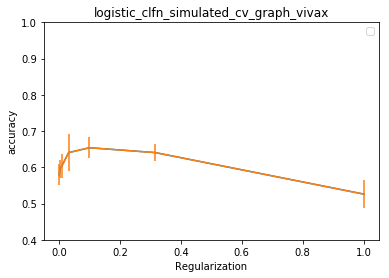

In [188]:
########################################################################
###### logistics classificator wrapper

if "log_clfn" in algo_active_list:
    t1 = time.time()
    clf_wrapper = ClassificatorWrapper(clf=SGDClassifier(random_state=42, n_jobs=n_jobs_log_clfn,tol=1e-3,max_iter=1000,loss="log"),
                                       cv_strategy=StratifiedKFoldByGroup(n_splits=CV_FOLDS, 
                                                                          shuffle=True, 
                                                                          random_state=42),
                                       gridsearch_params = {'alpha': cv_params_classifier}
                                      )

    clf_wrapper.fit(X=df_ml_data, y=y_ml_data, groups=y_label_ml_data
                     , restore_best_params_from=logistic_classifier_input_file
                   )  # GridSearch and CV are inside
    t2 = time.time(); print(t2 - t1)
    print(clf_wrapper.best_)  # classifier with best params retrained on whole train dataset

    ### Evaluate holdout
    eval_on_holdout = clf_wrapper.evaluate_on_holdout(df_test, y_test, label_enc, location_dict,filename=file_out_dict["file_out_log_clfn_holdout"])
    eval_on_holdout.head()

    print('Test accuracy = ', clf_wrapper.get_holdout_accuracy(eval_on_holdout))
    print('Mean distance error (km) = ', clf_wrapper.get_holdout_mean_distance_error(eval_on_holdout))

    clf_wrapper.get_grouped_holdout_stats(eval_on_holdout,filename=file_out_dict["file_out_log_clfn_holdout_grouped"])

    if calculate_out_of_folds==1:
        group_cv = GroupKFold(n_splits=len(set(y_label_ml_data)))
        oof_preds_2 = clf_wrapper.get_oof_predictions(X=df_ml_data, 
                                                      y=y_ml_data, 
                                                      groups=y_label_ml_data,
                                                      cv_strategy=group_cv,
                                                      location_dict=location_dict,
                                                      label_enc=label_enc,
                                                      filename=file_out_dict["file_out_log_clfn_oof_preds"]
                                                     )  # pass exactly the same params as for fit method
        print(accuracy_score(oof_preds_2.pred_location, oof_preds_2.true_location))
        print(oof_preds_2.head())
         
    plot_eval_on_holdout_sample(eval_on_holdout,save=plotting_enabled,save_fpath=file_out_dict["file_out_log_clfn_plot"]);

    _gs = clf_wrapper.get_gridsearch()
    if verbose==1:
        print(_gs.cv_results_)

    scores=summarize_crossval_accuracy(_gs)
    param_values_for_graph=_gs.cv_results_["param_clf__alpha"].compressed()

    if use_simulated_data==1:
        title_graph="logistic_clfn_simulated_cv_graph_vivax"
    else:
        pass

    plot_crossval(param_values_for_graph,scores,title_graph,_gs.cv_results_['std_test_score'])

outvar=df_ml_data.shape[1]
!echo $outvar > $log_class_success

In [189]:
if "log_clfn" in algo_active_list:
    coefficient_store=pd.DataFrame(columns=["values"])
    coefficient_store.loc["coef_count"]=clf_wrapper_count_nonzero_coefs(clf_wrapper, tol=1e-3, return_count=True)
    coefficient_store.loc["coef_share"]=clf_wrapper_count_nonzero_coefs(clf_wrapper, tol=1e-3, return_count=False)
    coefficient_store.to_csv(file_out_dict["file_out_log_clfn_coef"])
    clf_wrapper_count_nonzero_coefs(clf_wrapper, tol=1e-3, return_count=False)

restore best_params
1.7010281086
{'Lat': Pipeline(memory=None,
     steps=[('imputer', BinomialImputer()), ('reg', Lasso(alpha=0.31622776601683794, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=42, selection='cyclic', tol=0.0001, warm_start=False))]), 'Long': Pipeline(memory=None,
     steps=[('imputer', BinomialImputer()), ('reg', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))])}
Mean distance error (km) =  3460.03000603
5 fold
5 fold
   fold   mid_lat   mid_long  true_lat true_location_label  true_long  \
0     5  0.378264  -1.223240 -4.844681            Tanzania  38.962097   
1     5  7.883773   0.342490 -4.844681            Tanzania  38.962097   
2     5  7.883773   2.904298 -4.844681            Tanzania  38.962097   
3     5  9.450594  32.482790 -4.844681            Tan

Best: -71.405122 using {'reg__alpha': 0.31622776601683794}
[-209.99007331 -199.23508224 -162.94665835 -126.25935172  -85.8604719
  -71.40512171 -103.00749099] means
[{'reg__alpha': 0.001}, {'reg__alpha': 0.0031622776601683794}, {'reg__alpha': 0.01}, {'reg__alpha': 0.03162277660168379}, {'reg__alpha': 0.1}, {'reg__alpha': 0.31622776601683794}, {'reg__alpha': 1.0}] params
-209.990073 (11.971346) with: {'reg__alpha': 0.001}
-199.235082 (7.620393) with: {'reg__alpha': 0.0031622776601683794}
-162.946658 (12.173392) with: {'reg__alpha': 0.01}
-126.259352 (15.700235) with: {'reg__alpha': 0.03162277660168379}
-85.860472 (8.621746) with: {'reg__alpha': 0.1}
-71.405122 (3.223207) with: {'reg__alpha': 0.31622776601683794}
-103.007491 (1.635374) with: {'reg__alpha': 1.0}


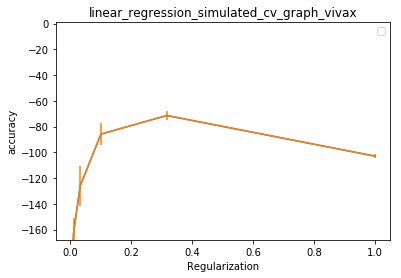

In [190]:
########################################################################
###### Linear Regressor wrapper

# TwoRegressorsWrapper requires dictionary of regressors to pass # keys should match with column names of df_geo ('Lat' and 'Long' in our case)
if "lin_reg" in algo_active_list:

    t1 = time.time()
    # We use the same gridsearch_params for all regressors
    _reg_dict = {
        'Lat': linear_model.Lasso(random_state=42),
        'Long': linear_model.Lasso(random_state=42)
        }
    reg_wrapper = TwoRegressorsWrapperV2(reg_dict=_reg_dict,
                                       cv_strategy=StratifiedKFoldByGroup(n_splits=CV_FOLDS, 
                                                                          shuffle=True, 
                                                                          random_state=42),
                                       gridsearch_params = {'alpha': cv_params_regression}
                                      )
    reg_wrapper.fit(X=df_ml_data, y=df_geo_ml_data, 
                    groups=y_label_ml_data, 
                     restore_best_params_from=linear_regression_input_file
                   )  # GridSearch and CV are inside

    t2 = time.time(); print(t2 - t1) ; t3=(t2-t1)

    print(reg_wrapper.best_dict)  # 2 regressors with best params retrained on whole train dataset

    ### Evaluate holdout
    ###>check
    eval_on_holdout = reg_wrapper.evaluate_on_holdout(df_test, df_geo_test, label_enc, location_dict,filename=file_out_dict["file_out_lin_regr_holdout"])
    eval_on_holdout.head()

    print('Mean distance error (km) = ', reg_wrapper.get_holdout_mean_distance_error(eval_on_holdout))

    reg_wrapper.get_grouped_holdout_stats(eval_on_holdout,filename=file_out_dict["file_out_lin_regr_holdout_grouped"])

    ## Plotting
    eval_on_holdout_sample = eval_on_holdout.sample(10, random_state=42).copy()

    if calculate_out_of_folds==1:
        group_cv = GroupKFold(n_splits=len(set(y_label_ml_data)))
        oof_preds_2 = reg_wrapper.get_oof_predictions(X=df_ml_data, 
                                                   y=df_geo_ml_data, 
                                                   groups=y_label_ml_data,
                                                   cv_strategy=group_cv,
                                                   filename=file_out_dict["file_out_lin_regr_oof_preds"]
                                                  ) 
        print(oof_preds_2.head())

    _gs_dict = reg_wrapper.get_gridsearch()
    if verbose==1:
        print(_gs_dict.keys())
        print(_gs_dict['Lat'].cv_results_)
    
    plot_eval_on_holdout_sample(eval_on_holdout_sample, save=plotting_enabled,save_fpath=file_out_dict["file_out_lin_regr_plot"]);

####cross_validation grpah 
if "lin_reg" in algo_active_list:
    scores=summarize_crossval_accuracy(_gs_dict['Lat'])
    param_values_for_graph=_gs_dict['Lat'].cv_results_["param_reg__alpha"].compressed()
    if use_simulated_data==1:
        title_graph="linear_regression_simulated_cv_graph_vivax"
    else:
        pass
    plot_crossval(param_values_for_graph,scores,title_graph,_gs_dict['Lat'].cv_results_['std_test_score'])

outvar=df_ml_data.shape[1]
!echo $outvar > $lin_regr_success

In [191]:
if "lin_reg" in algo_active_list:
    coefficient_store=pd.DataFrame(columns=["values"])
    coefficient_store.loc["coef_count"]=reg_wrapper_count_nonzero_coefs(reg_wrapper, tol=1e-5, return_count=True)
    coefficient_store.loc["coef_share"]=reg_wrapper_count_nonzero_coefs(reg_wrapper, tol=1e-5, return_count=False)
    coefficient_store.to_csv(file_out_dict["file_out_lin_regr_coef"])
    reg_wrapper_count_nonzero_coefs(reg_wrapper, tol=1e-5, return_count=False)

##### Keras

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_14 (Batc (None, 460)               1840      
_________________________________________________________________
dense_140 (Dense)            (None, 64)                29504     
_________________________________________________________________
dense_141 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_142 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_143 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_144 (Dense)            (None, 64)              

Epochs of train: 1200
Pipeline(memory=None,
     steps=[('imputer', BinomialImputer()), ('keras', <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fcc34304b90>)])


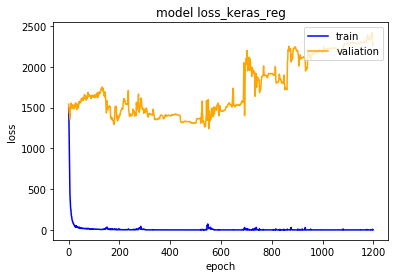

In [192]:
########################################################################
###### Keras regression wrapper
hh = tf.keras.callbacks.History()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_setting, verbose=2)

cnn_input_shape = (df_ml_data.shape[1], )
cnn_nclasses=len(set(y_ml_data)) ###number of geographies

if "keras_reg" in algo_active_list:
    m = make_model()
    print(m.summary())

    # create and fit wrapper   
    keras_wrapper = KerasWrapper(make_model_func=make_model, columns=['Lat', 'Long'], random_seed=seed_value)
    keras_wrapper.fit(X=df_ml_data, y=df_geo_ml_data,keras__callbacks=[hh],
                     keras__validation_data=(df_validation, df_geo_validation[['Lat', 'Long']])
                     )
    if verbose==1:
        print(keras_wrapper.best_)
    
     ### Evaluate holdout
    eval_on_holdout = keras_wrapper.evaluate_on_holdout(df_test, df_geo_test, label_enc, location_dict,filename=file_out_dict["file_out_keras_regr_holdout"])
    print(eval_on_holdout.head())
    print('Mean distance error (km) = ', keras_wrapper.get_holdout_mean_distance_error(eval_on_holdout))
    keras_wrapper.get_grouped_holdout_stats(eval_on_holdout,
                                            filename=file_out_dict["file_out_keras_regr_holdout_grouped"])


    ###OOF folds
    if calculate_out_of_folds==1:
        group_cv = GroupKFold(n_splits=len(set(y_label_ml_data)))
        oof_preds_2 = keras_wrapper.get_oof_predictions(X=df_ml_data, 
                                                      y=df_geo_ml_data, 
                                                      groups=y_label_ml_data,
                                                      cv_strategy=group_cv,
                                                      label_enc=label_enc,
                                                      filename=file_out_dict["file_out_keras_regr_oof_preds"]
                                                     )  # pass exactly the same params as for fit method
        print(oof_preds_2.head())

    plot_eval_on_holdout_sample(eval_on_holdout,save=plotting_enabled, save_fpath=file_out_dict["file_out_keras_regr_plot"]);

    print('Epochs of train:', len(hh.history['loss']))
    print(keras_wrapper.best_)

    try:
        performance_curve_loss(hh,"keras_reg")
    except:
        pass
    
if "keras_reg" in algo_active_list:
    outvar=df_ml_data.shape[1]
    !echo $outvar > $keras_regr_success

In [193]:
if "keras_reg" in algo_active_list:
    df_eval_grouped=keras_wrapper.get_grouped_holdout_stats(eval_on_holdout)

    ###get table without hold-out-locs
    try:
        df_eval_grouped=df_eval_grouped.drop([holdout_locs[0]])
    except:
        pass

    df_eval_grouped.loc['mean'] = df_eval_grouped.mean()
    df_eval_grouped=pd.DataFrame(df_eval_grouped["distance_to_midpoint"])
    df_eval_grouped

In [194]:
df_validation_es, y_validation_es = prepare_val_data_for_clf(df_validation, y_validation,  y_ml_data)

print(df_validation.shape, df_validation_es.shape, y_validation.shape, y_validation_es.shape)
print('y before OHE:', y_validation[y_validation.isin([1,2,3,4,5])].head().values)
print('y after OHE:')
y_validation_es.head()

(64, 460) (64, 460) (64,) (64, 6)
y before OHE: [2 3 5 4 5]
y after OHE:


,0,1,2,3,4,5
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0


In [195]:
if "keras_reg" in algo_active_list:
    coefficient_store=pd.DataFrame(columns=["values"])
    coefficient_store.loc["coef_count"]=keras_wrapper_count_nonzero_coefs(keras_wrapper, tol=1e-3, return_count=True)
    coefficient_store.loc["coef_share"]=keras_wrapper_count_nonzero_coefs(keras_wrapper, tol=1e-3, return_count=False)
    coefficient_store.to_csv(file_out_dict["file_out_keras_regr_coef"])
    keras_wrapper_count_nonzero_coefs(keras_wrapper, tol=1e-3, return_count=False)

In [197]:
def make_keras_classifier():
    model = tf.keras.Sequential()
    #opt=tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.add(tf.keras.layers.BatchNormalization(input_shape=cnn_input_shape))
    for i in range(int(np.floor(cnn_nlayers/2))):
        model.add(tf.keras.layers.Dense(cnn_width,activation="elu"))
        model.add(tf.keras.layers.Dropout(cnn_dropout_prop))
    for i in range(int(np.ceil(cnn_nlayers/2))):
        model.add(tf.keras.layers.Dense(cnn_width,activation="elu"))
    model.add(tf.keras.layers.Dense(cnn_nclasses, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer_selected, metrics=['accuracy']) ###used to be accuracy
    return model

Pipeline(memory=None,
     steps=[('imputer', BinomialImputer()), ('keras', <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcc70191790>)])
Test accuracy =  0.53125
Mean distance error (km) =  4063.36756715
5 fold
1      3
4      3
12     3
15     3
16     3
19     3
20     3
25     3
28     3
50     3
58     3
64     3
66     3
74     3
76     3
80     3
84     3
91     3
93     3
96     3
119    3
126    3
134    3
137    3
147    3
148    3
154    3
155    3
157    3
161    3
      ..
298    3
300    3
301    3
306    3
314    3
317    3
320    3
329    3
333    3
345    3
350    3
351    3
362    3
363    3
383    3
388    3
389    3
393    3
395    3
402    3
408    3
414    3
437    3
449    3
451    3
455    3
463    3
479    3
490    3
502    3
Length: 84, dtype: int64 y_test
0      2
2      1
3      2
5      1
6      4
7      4
8      1
9      0
10     1
11     2
13     4
14     5
17     5
18     2
21     1
22     5
23     1
24     5
26     4
27    

0.0
   fold  pred_location  true_location pred_location_label true_location_label  \
0     5              4              3            Thailand            Tanzania   
1     5              0              3               Ghana            Tanzania   
2     5              0              3               Ghana            Tanzania   
3     5              1              3          Mauritania            Tanzania   
4     5              5              3              Zambia            Tanzania   

     mid_lat   mid_long  true_lat  true_long  distance_to_midpoint  
0  16.792667  98.606285 -4.844681  38.962097           6981.714857  
1  10.805717  -1.500308 -4.844681  38.962097           4806.188576  
2  10.885572  -1.086558 -4.844681  38.962097           4766.374607  
3  16.519151  -7.533301 -4.844681  38.962097           5635.723136  
4 -11.812396  30.675708 -4.844681  38.962097           1194.107732  


Epochs of train: 1200
Pipeline(memory=None,
     steps=[('imputer', BinomialImputer()), ('keras', <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fcd14096490>)])


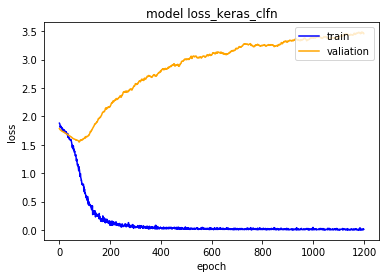

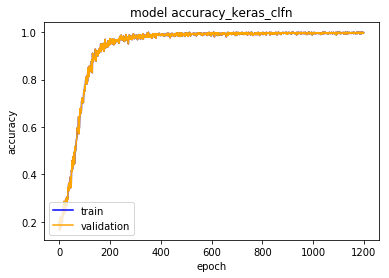

In [198]:
########################################################################
##### Keras classification wrapper

#import keras
hh = tf.keras.callbacks.History()
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=patience_setting, verbose=1)
#mc = tf.keras.callbacks.ModelCheckpoint('best_model_keras_clfn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
cnn_input_shape = (df_ml_data.shape[1], )
cnn_nclasses=len(set(y_ml_data)) ###number of geographies

if "keras_clfn" in algo_active_list:
    #print(optimizer, "=optimizer")
    m = make_keras_classifier()
    #m.summary()

    ##### model fit with callbacks 
    # create and fit wrapper   
    keras_cls_wrapper = KerasClassifierWrapper(make_model_func=make_keras_classifier)
    keras_cls_wrapper.fit(X=df_ml_data.iloc[:], y=y_ml_data.iloc[:],keras__callbacks=[hh],
                    keras__validation_data=(df_validation_es,y_validation_es),
                     )
    keras_cls_wrapper.predict_proba(df_test, filename=None)
    print(keras_cls_wrapper.best_)

    ### Evaluate holdout
    eval_on_holdout = keras_cls_wrapper.evaluate_on_holdout(df_test, y_test, label_enc, location_dict,
                                                            filename=file_out_dict["file_out_keras_clfn_holdout"])
    #print(eval_on_holdout.head())

    print('Test accuracy = ', keras_cls_wrapper.get_holdout_accuracy(eval_on_holdout))
    print('Mean distance error (km) = ', keras_cls_wrapper.get_holdout_mean_distance_error(eval_on_holdout))

    keras_cls_wrapper.get_grouped_holdout_stats(eval_on_holdout,
                                                filename=file_out_dict["file_out_keras_clfn_holdout_grouped"])

    if calculate_out_of_folds==1:
        group_cv = GroupKFold(n_splits=len(set(y_label_ml_data)))
        oof_preds_2 = keras_cls_wrapper.get_oof_predictions(X=df_ml_data, 
                                                      y=y_ml_data, 
                                                      groups=y_label_ml_data,
                                                      cv_strategy=group_cv,
                                                      location_dict=location_dict,
                                                      label_enc=label_enc,
                                                      filename=file_out_dict["file_out_keras_clfn_oof_preds"]
                                                     )  # pass exactly the same params as for fit method
        print(accuracy_score(oof_preds_2.pred_location, oof_preds_2.true_location))
        print(oof_preds_2.head())

    plot_eval_on_holdout_sample(eval_on_holdout,save=plotting_enabled,
                                save_fpath=file_out_dict["file_out_keras_clfn_plot"]);

if "keras_clfn" in algo_active_list:

    print('Epochs of train:', len(hh.history['loss']))
    print(keras_cls_wrapper.best_)

    performance_curve_loss(hh,"keras_clfn")
    performance_curve_metric(hh,"keras_clfn")

    outvar=df_ml_data.shape[1]
    if "keras_clfn" in algo_active_list:
        !echo $outvar > $keras_classifier_success

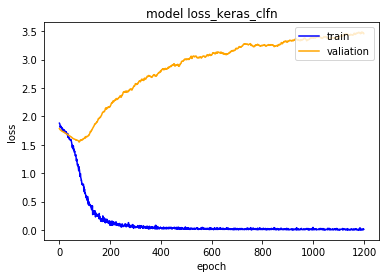

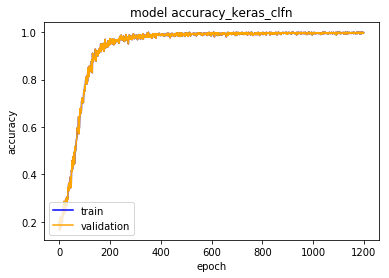

In [199]:
if "keras_clfn" in algo_active_list:
    performance_curve_loss(hh,"keras_clfn")
    performance_curve_metric(hh,"keras_clfn")

In [200]:
if "keras_clfn" in algo_active_list:
    print(np.mean(hh.history['val_accuracy'][-10:]))

0.6


In [201]:
# we can use the same function here as we did for keras regressor
if "keras_clfn" in algo_active_list:
    coefficient_store=pd.DataFrame(columns=["values"])
    coefficient_store.loc["coef_count"]=keras_wrapper_count_nonzero_coefs(keras_cls_wrapper, tol=1e-30, return_count=True)
    coefficient_store.loc["coef_share"]=keras_wrapper_count_nonzero_coefs(keras_cls_wrapper, tol=1e-30, return_count=False)
    coefficient_store.to_csv(file_out_dict["file_out_keras_clfn_coef"])
    keras_wrapper_count_nonzero_coefs(keras_cls_wrapper, tol=1e-30, return_count=True)

In [202]:
###map countries to regions, then do pca byt region, then do by country
df_regions=pd.read_excel("Country_Region_Mapping.xlsx")
df_regions.columns=["country","region"]
df_geo_full_expanded=pd.merge(df_geo_full,df_regions,  how='left', left_on="Location",right_on="country")

In [203]:
df_geo_full_expanded.to_csv("inspectregions.csv")

In [204]:
def run_and_plot_PDA(df_full,df_geo_full_expanded,subset,inverse,grouping_level,n_components=2,title_graph=None):
    boolean=df_geo_full_expanded["region"].isin([subset])
    boolean=np.array(boolean)
    print(boolean.shape)
    if inverse==True:
        boolean=~boolean
    if subset=="all":
        pass
    else:
        df_full=df_full[boolean]
        df_geo_full_expanded=df_geo_full_expanded[boolean]
    pca = PCA(n_components)
    pca_array = pca.fit_transform(df_full.values)
    groupslist=list(df_geo_full_expanded[grouping_level])

    colors = ['r', 'b', 'g']
    markers = ['s', 'x', 'o']

    for l in np.unique(groupslist):
        plt.scatter(pca_array[np.array(groupslist)==l, 0], 
                    pca_array[np.array(groupslist)==l, 1], 
                    label=l)    
    #                    c=c, label=l, marker=m) 
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc='upper right',bbox_to_anchor=(0, 1))
    plt.title(title_graph)
    plt.show()

(636,)


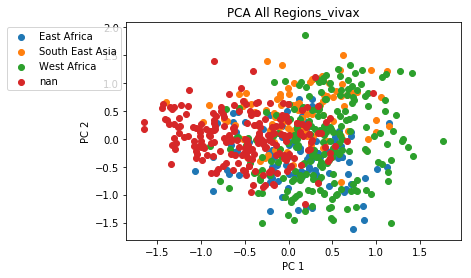

In [205]:
###############################
##### pca
if "pca" in algo_active_list: 
    run_and_plot_PDA(df_full,df_geo_full_expanded,subset="all",inverse=False,grouping_level="region",n_components=2,title_graph="PCA All Regions_vivax")

(636,)


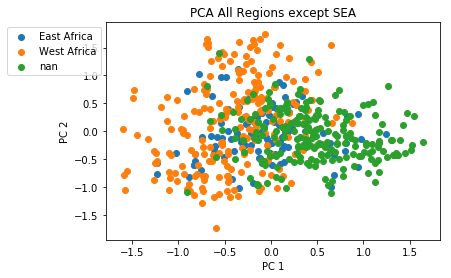

In [206]:
if "pca" in algo_active_list:
    run_and_plot_PDA(df_full,df_geo_full_expanded,subset="South East Asia",inverse=True,grouping_level="region",n_components=2,title_graph="PCA All Regions except SEA")

(636,)


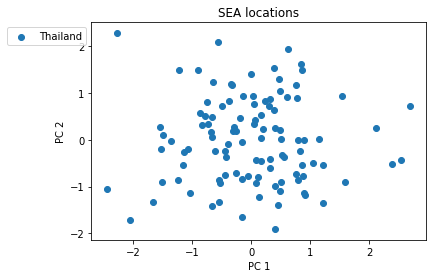

In [207]:
if "pca" in algo_active_list:
    run_and_plot_PDA(df_full,df_geo_full_expanded,subset="South East Asia",inverse=False,grouping_level="Location",n_components=2,title_graph="SEA locations")

(636,)


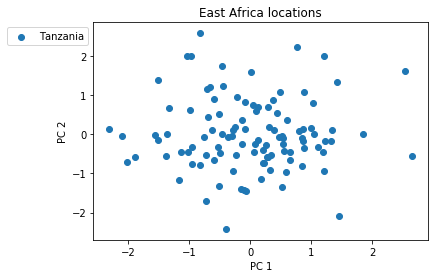

In [208]:
if "pca" in algo_active_list:
    run_and_plot_PDA(df_full,df_geo_full_expanded,subset="East Africa",inverse=False,grouping_level="Location",n_components=2,title_graph="East Africa locations")

(636,)


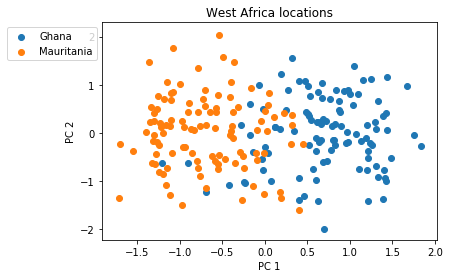

In [209]:
if "pca" in algo_active_list:
    run_and_plot_PDA(df_full,df_geo_full_expanded,subset="West Africa",inverse=False,grouping_level="Location",n_components=2,title_graph="West Africa locations")